In [1]:
import pandas as pd #For reading dataset files
import networkx as nx #For network creation/analysis
from networkx.algorithms import community
import community as community_louvain
import matplotlib.pyplot as plt #For plotting graphs
import igraph as ig
import numpy as np
import leidenalg as la
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    f1_score,
    confusion_matrix,
)
from collections import Counter
from networkx.algorithms.community import label_propagation_communities
from cdlib import algorithms

from modularitydensity.metrics import modularity_density
import community as louvain
import leidenalg as la
from cdlib.algorithms import louvain

from cdlib import evaluation

import random


np.random.seed(42)  # Imposta il seed per NumPy
random.seed(42)

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap', 'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'infomap'}


# Login dataset

Comunità 'Mr. Hi': [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
Comunità 'Officer': [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


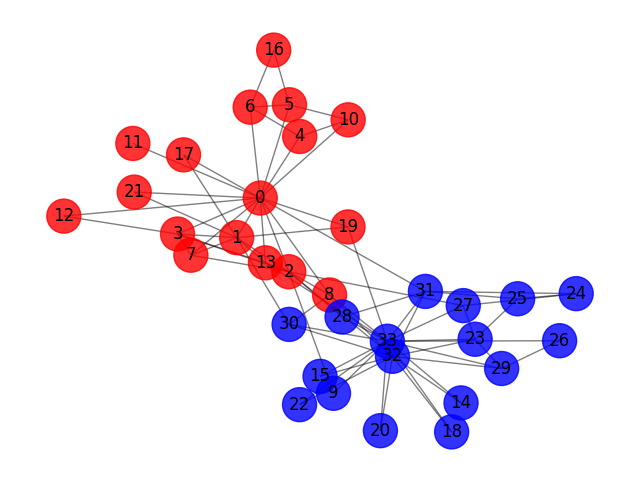

In [2]:
# Crea il grafo del Karate Club di Zachary
G = nx.karate_club_graph()

# Estrai le comunità ground truth basate sull'attributo 'club'
ground_truth_communities = {
    'Mr. Hi': [n for n, d in G.nodes(data=True) if d['club'] == 'Mr. Hi'],
    'Officer': [n for n, d in G.nodes(data=True) if d['club'] == 'Officer']
}

# Stampa le liste delle comunità
print("Comunità 'Mr. Hi':", ground_truth_communities['Mr. Hi'])
print("Comunità 'Officer':", ground_truth_communities['Officer'])

# Assegna un colore diverso per ogni comunità
color_map = []
for node in G.nodes():
    if node in ground_truth_communities['Mr. Hi']:
        color_map.append('red')  # Colore per i nodi appartenenti alla comunità 'Mr. Hi'
    else:
        color_map.append('blue')  # Colore per i nodi appartenenti alla comunità 'Officer'

# Definisci il layout per la visualizzazione
pos = nx.spring_layout(G)

# Disegna il grafo con i colori della ground truth
plt.figure(figsize=(8, 6))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=600, alpha=0.8)
nx.draw_networkx_labels(G, pos)

# Titolo per indicare che sono le comunità della ground truth

plt.axis("off")
plt.show()

In [3]:
def calcola_metriche(comunita_attese, comunita_rilevate, adjacency_matrix):
    # Preparazione dei dati per ARI e NMI
    true_labels = np.array([0] * 34)  # 0 per 'Mr. Hi', 1 per 'Officer'
    for node in comunita_attese['Officer']:
        true_labels[node] = 1

    predicted_labels = np.array([-1] * 34)  # Valori non assegnati    
    for cluster_id, nodes in comunita_rilevate.items():
        for node in nodes:
            predicted_labels[node] = cluster_id

    # Calcolo delle metriche
    ari = adjusted_rand_score(true_labels, predicted_labels)
    ami = adjusted_mutual_info_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)

    # Calcolo dell'HS
    hs = homogeneity_score(true_labels, predicted_labels)

    # Calcolo del CS
    cs = completeness_score(true_labels, predicted_labels)

    # Calcolo della F1 Score
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Calcolo della Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Calcolo della Modularity Density
    md = modularity_density(adjacency_matrix, comunita_rilevate)

    # Calcolo della Community Score
    cs_score = community_score(adjacency_matrix, comunita_rilevate)

    # Calcolo della Community Fitness
    fitness = community_fitness(adjacency_matrix, comunita_rilevate)

    # Stampa dei risultati
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Adjusted Mutual Information (AMI): {ami:.4f}")
    print(f"Homogeneity Score (HS): {hs:.4f}")
    print(f"Completeness Score (CS): {cs:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"Modularity Density: {md:.4f}")
    print(f"Community Score: {cs_score:.4f}")
    print(f"Community Fitness: {fitness:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

    # Risultati da visualizzare
    metriche = {
        'ARI': ari,
        'AMI': ami,
        'HS': hs,
        'CS': cs,
        'F1 Score': f1,
        'Modularity Density': md,
        'Community Score': cs_score,
        'Community Fitness': fitness,
        'NMI': nmi
    }

    return metriche

    # Creazione del grafico a barre
    plt.figure(figsize=(10, 6))
    plt.bar(metriche.keys(), metriche.values(), color='skyblue')
    plt.ylabel('Valore')
    plt.title('Metriche di Rilevamento delle Comunità')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Limite dell'asse y per una migliore visualizzazione
    plt.grid(axis='y')

    # Mostra il grafico
    plt.tight_layout()
    plt.show()


    x = np.arange(len(labels))  # la posizione delle etichette

    # Creazione del grafico
    plt.figure(figsize=(10, 6))
    bar_width = 0.35

    # Barre per le comunità attese
    plt.bar(x - bar_width / 2, true_values, width=bar_width, label='Comunità Attese', color='skyblue')

    # Barre per le comunità rilevate
    plt.bar(x + bar_width / 2, predicted_values, width=bar_width, label='Comunità Rilevate', color='salmon')

    # Aggiunta delle etichette e della leggenda
    plt.xlabel('Comunità')
    plt.ylabel('Numero di Nodi')
    plt.title('Confronto tra Comunità Attese e Rilevate')
    plt.xticks(x, ['Mr. Hi', 'Officer'])
    plt.legend()
    plt.grid(axis='y')

    # Mostra il grafico
    plt.tight_layout()
    plt.show()

#  Funzioni di supporto 
def modularity_density(adjacency_matrix, comunita_rilevate):
    k = len(comunita_rilevate)  # Numero di comunità
    densita = 0.0  # Inizializza la densità a zero

    for community in comunita_rilevate.values():
        V_c = len(community)  # Numero di nodi nella comunità
        E_c = 0  # Inizializza il conteggio degli archi nella comunità

        # Calcola il numero di archi tra i nodi nella comunità
        for i in range(V_c):
            for j in range(i + 1, V_c):  # Evita il conteggio doppio
                # Usa gli indici della matrice di adiacenza per controllare se esiste un arco
                if adjacency_matrix[community[i], community[j]] > 0:
                    E_c += 1

        # Calcola la densità della comunità
        if V_c > 1:  # Evita divisioni per zero
            densita += E_c / (V_c * (V_c - 1))

    # Calcola la densità modulare finale
    if k > 0:  # Evita divisioni per zero
        densita_modulare = densita / k
    else:
        densita_modulare = 0

    return densita_modulare

def community_score(adjacency_matrix, comunita_rilevate):
    internal_edges = 0
    total_edges = 0
    for i in range(len(adjacency_matrix)):
        for j in range(i+1, len(adjacency_matrix)):
            if adjacency_matrix[i, j] > 0:
                total_edges += 1
                for community in comunita_rilevate.values():
                    if i in community and j in community:
                        internal_edges += 1
                        break  # Una volta trovato, puoi uscire dal ciclo
    
    if total_edges == 0:
        return 0  # Evita divisioni per zero
    
    # Community Score è il rapporto tra archi interni e archi totali
    return internal_edges / total_edges    
        


def community_fitness(adjacency_matrix, comunita_rilevate):
    internal_edges = 0
    external_edges = 0

    # Mappa i nodi a quale comunità appartengono
    node_to_community = {}
    for community_id, nodes in comunita_rilevate.items():
        for node in nodes:
            node_to_community[node] = community_id

    num_nodes = adjacency_matrix.shape[0]  # Assicurati che la matrice sia quadrata

    for i in range(num_nodes):
        for j in range(num_nodes):
            if adjacency_matrix[i, j] > 0:  # Se esiste un arco
                if node_to_community.get(i) == node_to_community.get(j):  # Se appartengono alla stessa comunità
                    internal_edges += 1
                else:
                    external_edges += 1

    if internal_edges + external_edges == 0:
        return 0  # Evita divisioni per zero

    return internal_edges / (internal_edges + external_edges)

# Label propagation

Community 1: [32, 33, 2, 8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 28, 29, 30]
Community 2: [0, 1, 3, 4, 7, 10, 11, 12, 13, 17, 19, 21, 24, 25, 31]
Community 3: [16, 5, 6]


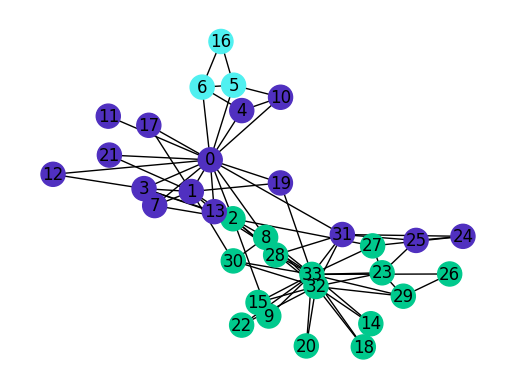

Adjusted Rand Index (ARI): 0.3833
Adjusted Mutual Information (AMI): 0.3353
Homogeneity Score (HS): 0.4257
Completeness Score (CS): 0.3173
F1 Score: 0.1544
Confusion Matrix:
[[ 2 12  3]
 [14  3  0]
 [ 0  0  0]]
Modularity Density: 0.2508
Community Score: 0.7692
Community Fitness: 0.7692
Normalized Mutual Information (NMI): 0.3636


In [4]:
community_graph = nx.Graph() 
# Rilevamento delle comunità con l'algoritmo Label Propagation
communities= algorithms.label_propagation(G).communities
community_dict_label_propagation = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#00C98D", "#5030C0", "#50F0F0", 'yellow']

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Mr. Hi': [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
    'Officer': [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
}

adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_label_propagation = calcola_metriche(ground_truth_communities, community_dict_label_propagation, adj_matrix_full)

# Louvain

Community 1: [8, 9, 14, 15, 18, 20, 22, 23, 26, 27, 29, 30, 32, 33]
Community 2: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 3: [4, 5, 6, 10, 16]
Community 4: [24, 25, 28, 31]


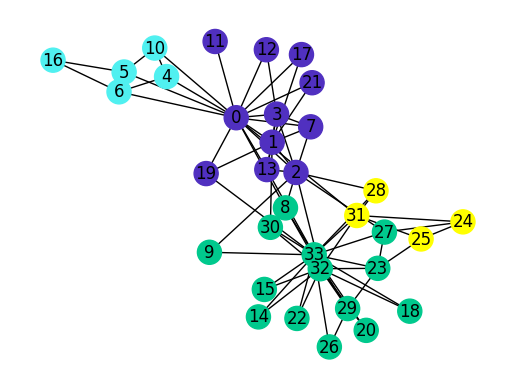

Adjusted Rand Index (ARI): 0.5089
Adjusted Mutual Information (AMI): 0.5782
Homogeneity Score (HS): 0.8471
Completeness Score (CS): 0.4645
F1 Score: 0.0323
Confusion Matrix:
[[ 1 11  5  0]
 [13  0  0  4]
 [ 0  0  0  0]
 [ 0  0  0  0]]
Modularity Density: 0.2463
Community Score: 0.7564
Community Fitness: 0.7564
Normalized Mutual Information (NMI): 0.6000


In [5]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)

# Mappa ogni nodo alla sua comunitàpos = nx.spring_layout(G)
communities = algorithms.louvain(G).communities
community_dict_louvain = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#00C98D", "#5030C0", "#50F0F0", 'yellow']

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1

nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Mr. Hi': [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
    'Officer': [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
}

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_louvain = calcola_metriche(ground_truth_communities, community_dict_louvain, adj_matrix_full)

# Leiden

Community 1: [8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33]
Community 2: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Community 3: [23, 24, 25, 27, 28, 31]
Community 4: [4, 5, 6, 10, 16]


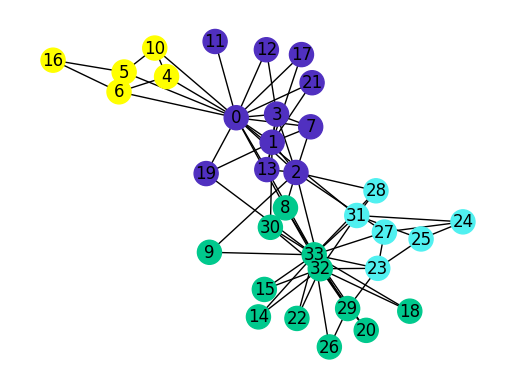

Adjusted Rand Index (ARI): 0.4646
Adjusted Mutual Information (AMI): 0.5667
Homogeneity Score (HS): 0.8539
Completeness Score (CS): 0.4482
F1 Score: 0.0345
Confusion Matrix:
[[ 1 11  0  5]
 [11  0  6  0]
 [ 0  0  0  0]
 [ 0  0  0  0]]
Modularity Density: 0.2254
Community Score: 0.7308
Community Fitness: 0.7308
Normalized Mutual Information (NMI): 0.5878


In [6]:
np.random.seed(43)
random.seed(43)

pos = nx.spring_layout(G)

g_igraph = ig.Graph.Adjacency((nx.to_numpy_array(G) > 0).tolist())

communities = la.find_partition(g_igraph, la.ModularityVertexPartition, seed=43)

community_dict_leiden = {i: community for i, community in enumerate(communities)}

for i, community in enumerate(communities):
    print(f"Community {i + 1}: {community}")

community_list=list(communities)

# Mappa ogni nodo alla sua comunità
node_to_community = {}
for i, community in enumerate(community_list):
    for node in community:
        node_to_community[node] = i


# Aggiungi gli archi tra le comunità se c'è una connessione tra nodi di comunità diverse
for u, v in G.edges():
    comm_u = node_to_community[u]
    comm_v = node_to_community[v]
    if comm_u != comm_v:
        community_graph.add_edge(comm_u, comm_v)

colors = ["#00C98D", "#5030C0", "#50F0F0", 'yellow']

color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in community_list:
  for n in c:
    color_map_b[n] = colors[counter]
  counter = counter + 1


nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Mr. Hi': [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
    'Officer': [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
}

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_leiden = calcola_metriche(ground_truth_communities, community_dict_leiden, adj_matrix_full)


# Conga

Communities detected:
Communità 1: [2, 3, 7, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 0, 1]
Communità 2: [0, 1, 4, 5, 6, 10, 11, 12, 16, 17, 21]


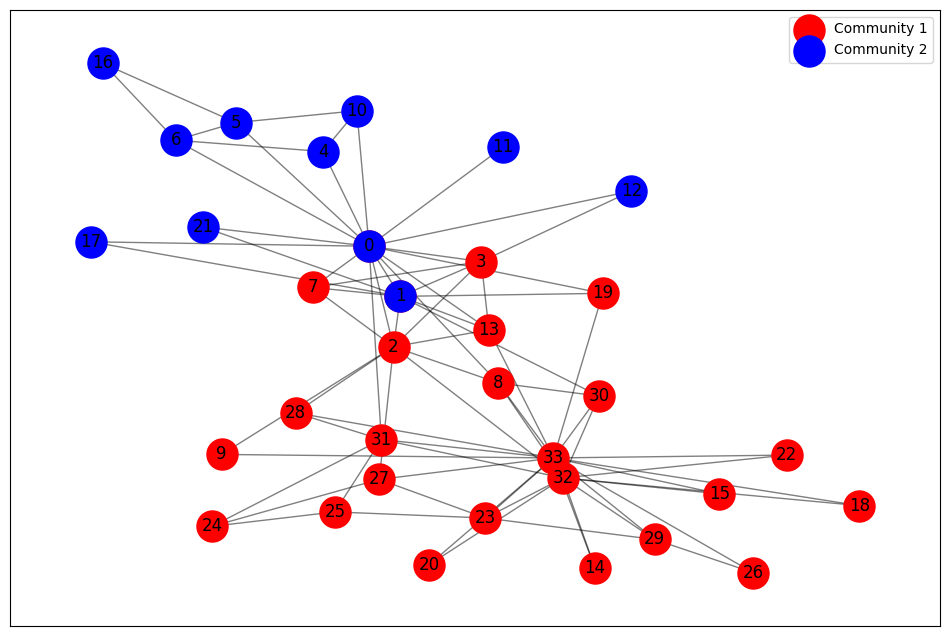

Adjusted Rand Index (ARI): 0.4028
Adjusted Mutual Information (AMI): 0.4480
Homogeneity Score (HS): 0.4398
Completeness Score (CS): 0.4843
F1 Score: 0.1500
Confusion Matrix:
[[ 6 11]
 [17  0]]
Modularity Density: 0.1281
Community Score: 0.9872
Community Fitness: 0.8205
Normalized Mutual Information (NMI): 0.4610


In [7]:
# Run the CONGA algorithm

com = algorithms.conga(G, number_communities=2)
community_dict = {i: community for i, community in enumerate(com.communities)}

# Print the detected communities
print("Communities detected:")
for i, community in enumerate(com.communities):
    print(f"Communità {i + 1}: {community}")

# Prepare for visualization
pos = nx.spring_layout(G)  # Layout for the nodes
colors = (['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow'])  # Cycle through colors

# Draw the graph with community coloring
plt.figure(figsize=(12, 8))
for community, color in zip(com.communities, colors):
    nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=color, label=f"Community {com.communities.index(community) + 1}", node_size=500)


# Draw the edges
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos)

# Add a legend and show the plot
plt.legend(scatterpoints=1)
plt.show()


# Definisci le comunità attese come un dizionario
ground_truth_communities = {
    'Mr. Hi': [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21],
    'Officer': [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
}

# Calcola le metriche
adj_matrix_full = nx.adjacency_matrix(G).todense()
risultati_conga = calcola_metriche(ground_truth_communities, community_dict, adj_matrix_full)

# Risultati

                    Label Propagation   Louvain    Leiden     Conga
ARI                          0.383312  0.508864  0.464591  0.402844
AMI                          0.335286  0.578238  0.566666  0.448029
HS                           0.425707  0.847140  0.853947  0.439845
CS                           0.317306  0.464505  0.448190  0.484315
F1 Score                     0.154356  0.032258  0.034483  0.150000
Modularity Density           0.250794  0.246320  0.225379  0.128106
Community Score              0.769231  0.756410  0.730769  0.987179
Community Fitness            0.769231  0.756410  0.730769  0.820513
NMI                          0.363599  0.600011  0.587850  0.461010
Numero di Comunità           3.000000  4.000000  4.000000  2.000000


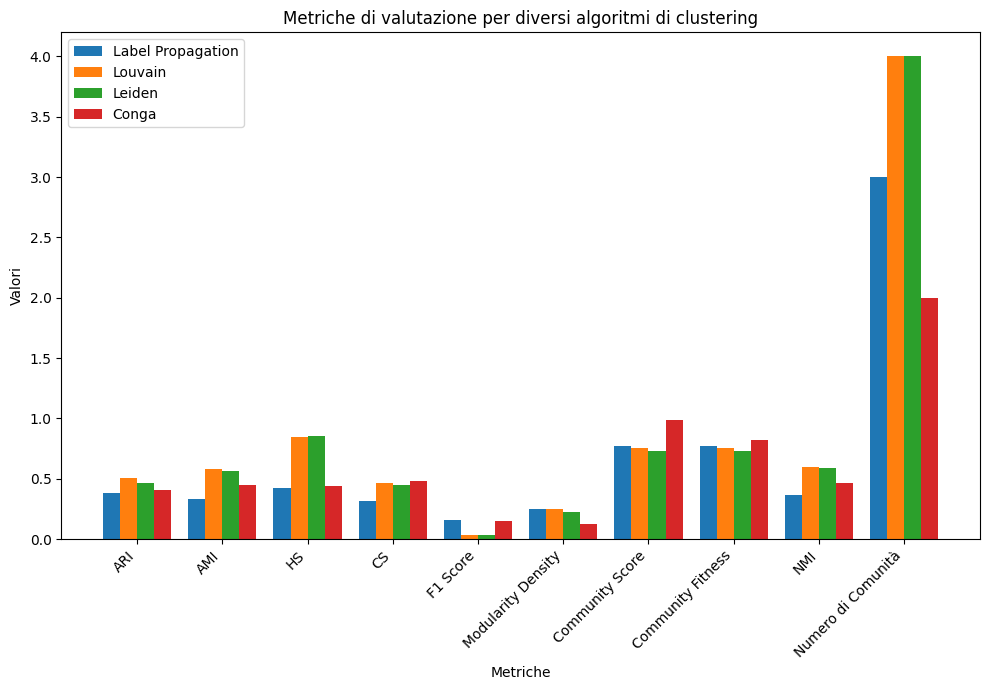

In [8]:
# Aggiungi il numero delle comunità rilevate per ciascun algoritmo nei risultati
risultati = {
    "Label Propagation": {**risultati_label_propagation, "Numero di Comunità": len(community_dict_label_propagation)},
    "Louvain": {**risultati_louvain, "Numero di Comunità": len(community_dict_louvain)},
    "Leiden": {**risultati_leiden, "Numero di Comunità": len(community_dict_leiden)},
    "Conga": {**risultati_conga, "Numero di Comunità": len(community_dict)}
}

# Creazione di un DataFrame dalle metriche ottenute per ogni algoritmo, inclusi il numero di comunità
df_risultati = pd.DataFrame(risultati)

# Visualizzazione del DataFrame per vedere i risultati
print(df_risultati)

# Imposta dimensioni della figura per il grafico
fig, ax = plt.subplots(figsize=(10, 7))

# Definire le posizioni delle barre
n_misure = len(df_risultati.index)
bar_width = 0.2
index = np.arange(n_misure)

# Plot delle barre
for i, algoritmo in enumerate(df_risultati.columns):
    ax.bar(index + i * bar_width, df_risultati[algoritmo], bar_width, label=algoritmo)

# Aggiungere etichette e titolo
ax.set_xlabel('Metriche')
ax.set_ylabel('Valori')
ax.set_title('Metriche di valutazione per diversi algoritmi di clustering')

# Configurazione delle etichette per l'asse X
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(df_risultati.index, rotation=45, ha='right')

# Aggiungere legenda
ax.legend()

# Mostrare il grafico
plt.tight_layout()
plt.show()
